## Load Data and Initial Grid Search

In [1]:
DATA_NAME = 'approx1e5-spaceNet-fourier-gray' # size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'group')
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\spaceNet\\fourier\\approx1e5\\gray'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
print("Check that this <= 1e5 if approx1e5:", group_data_map[sorted(group_data_map)[-1]].size)
group_total_samples 

Check that this <= 1e5 if approx1e5: 100000


{2: 47614,
 3: 54416,
 4: 61218,
 5: 102030,
 6: 156446,
 7: 197258,
 8: 326496,
 9: 421724,
 10: 639388,
 11: 904666,
 12: 1312786,
 13: 1904560,
 14: 2727602,
 15: 3958764,
 16: 5720482,
 17: 8298440,
 18: 11957916,
 19: 17270278,
 20: 25140192,
 21: 36322680,
 22: 52586262,
 23: 65734528}

In [5]:
def create_kurt_var_ksstat_df(cdf_dict):
    cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(cdf_dict.items())})
    cdfs_df['r'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[0])
    cdfs_df['eta'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[1])
    cdfs_df['cdf'] = pd.Series(cdfs_df["(r,eta),cdf"].str[1])
    cdfs_df['variance'] = np.nan_to_num(cdfs_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
    cdfs_df['kurtosis'] = cdfs_df.apply(lambda row : kurtosis_prior(row.loc['r'], row.loc['eta']), axis = 1)
    return cdfs_df

In [6]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:817: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:822: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:822: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:822: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


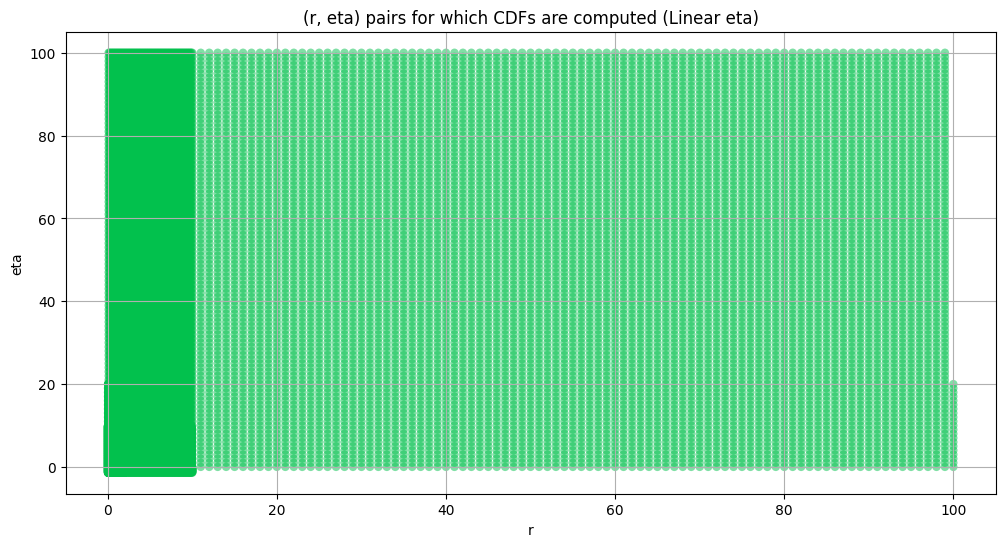

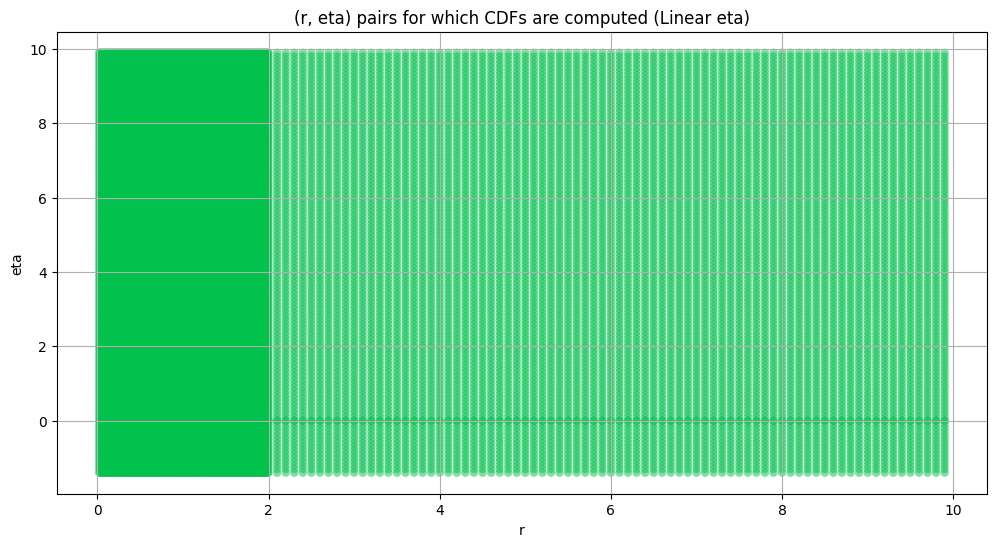

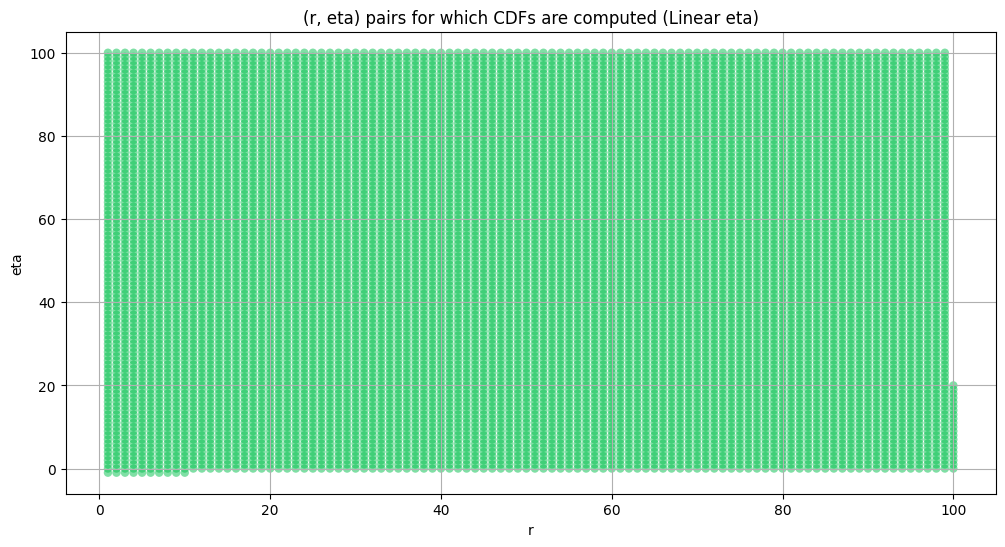

c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,r,eta,variance,kurtosis
count,51883.000000,51883.000000,5.188300e+04,5.064200e+04
mean,11.990701,21.476312,inf,inf
std,22.639851,28.237512,inf,NaN
min,0.020000,-1.400000,0.000000e+00,4.787254e-04
25%,1.000000,3.000000,9.882555e-01,1.513901e-02
50%,1.970000,7.600000,1.482803e+00,1.950077e-01
75%,8.100000,32.000000,5.742021e+00,6.565170e-01
max,100.000000,100.000000,1.797693e+308,inf


In [7]:
create_scatter_plot(all_cdfs_df)
create_scatter_plot(all_cdfs_df[(all_cdfs_df['r'] < 10) & (all_cdfs_df['eta'] < 10)])
create_scatter_plot(coarse_cdf_df)

all_cdfs_df.describe()

In [8]:
n_bootstrap = int(1e4)
bootstrap_size = int(1e5)
ci = 0.99

In [9]:
''' Only need to run commented code once'''    
for group in  GROUPS:
    print(f'{GROUP.capitalize()} {group}')
    obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                             n_bootstrap=n_bootstrap, 
                                                                             bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                             metric= np.var, 
                                                                             ci=ci)
    obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                 n_bootstrap=n_bootstrap, 
                                                                                 bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                 metric= stats.kurtosis, ci=ci)  
    master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
    master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
    master_df.loc[group, 'total_samples'] = group_total_samples[group]

master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
var_kurt_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
master_df

Band 2


100%|██████████| 10000/10000 [01:21<00:00, 123.08it/s]


Band 5


100%|██████████| 10000/10000 [01:59<00:00, 83.72it/s]


Band 8


100%|██████████| 10000/10000 [02:00<00:00, 83.29it/s]


Band 11


100%|██████████| 10000/10000 [01:53<00:00, 88.32it/s]


Band 14


100%|██████████| 10000/10000 [01:58<00:00, 84.10it/s]


Band 17


100%|██████████| 10000/10000 [01:57<00:00, 85.31it/s]


Band 20


100%|██████████| 10000/10000 [01:56<00:00, 86.15it/s]


Band 23


100%|██████████| 10000/10000 [02:00<00:00, 82.73it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,2.108037e+08,2.039314e+08,2.177806e+08,5.938153,5.064412,6.961090,47614.0
5,8.466665e+07,8.227714e+07,8.714032e+07,10.238721,8.741003,12.021282,102030.0
8,2.441800e+07,2.372345e+07,2.514127e+07,10.654582,8.485845,14.080202,326496.0
11,6.095848e+06,5.934529e+06,6.261906e+06,9.481828,7.939621,11.507581,904666.0
14,1.795079e+06,1.744169e+06,1.849945e+06,11.123093,8.074008,16.063778,2727602.0
17,4.415782e+05,4.224831e+05,4.687009e+05,38.040094,9.508811,106.765547,8298440.0
20,7.319305e+04,6.723740e+04,8.394759e+04,212.947004,10.371002,573.653227,25140192.0
23,1.741782e+04,1.671122e+04,1.850959e+04,38.076744,6.192983,112.367262,65734528.0


In [10]:
def add_tests_to_df(cdfs_df, group, var_kurt_df, ksstats):
    cdfs_df['pass_var'] = (cdfs_df['variance'] > var_kurt_df.loc[group, 'var_lower']) & (cdfs_df['variance'] < var_kurt_df.loc[group, 'var_upper'])
    cdfs_df['pass_kurt'] = (cdfs_df['kurtosis'] > var_kurt_df.loc[group, 'kurt_lower']) & (cdfs_df['kurtosis'] < var_kurt_df.loc[group,'kurt_upper'])
    cdfs_df['ksstat'] = ksstats
    cutoff = stats.kstwo(n=var_kurt_df.loc[group, 'total_samples']).isf(0.05)
    cdfs_df['pass_kstest'] = cdfs_df['ksstat'].apply(lambda x: True if x < cutoff else False)
    return cdfs_df

####
Band  2


100%|██████████| 51883/51883 [11:42<00:00, 73.84it/s] 


Finding Minimum after computing 51883 CDFs
Number of samples: 47614, Without approximation : 47614.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


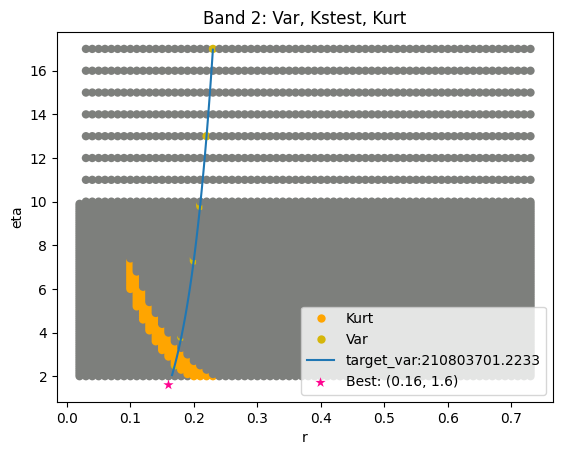

####
Band  5


100%|██████████| 51883/51883 [26:31<00:00, 32.60it/s]  


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 102030.0


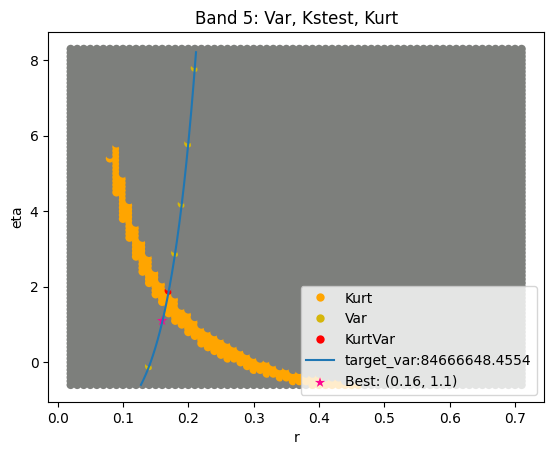

####
Band  8


100%|██████████| 51883/51883 [20:21<00:00, 42.47it/s]  


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 326496.0


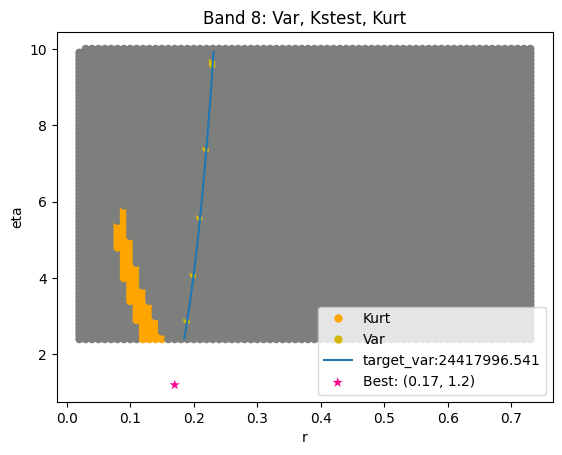

####
Band  11


100%|██████████| 51883/51883 [18:06<00:00, 47.77it/s]  


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 904666.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


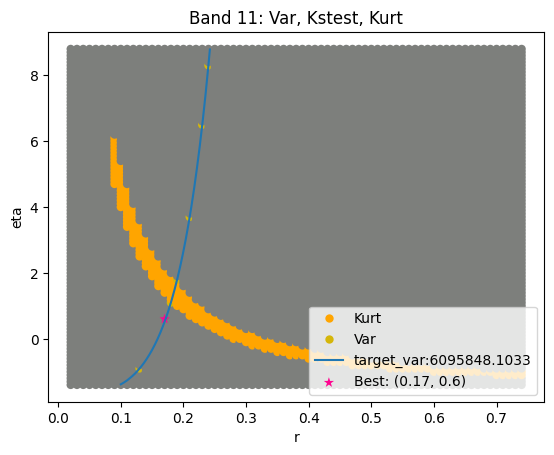

####
Band  14


100%|██████████| 51883/51883 [18:47<00:00, 46.01it/s] 


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 2727602.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


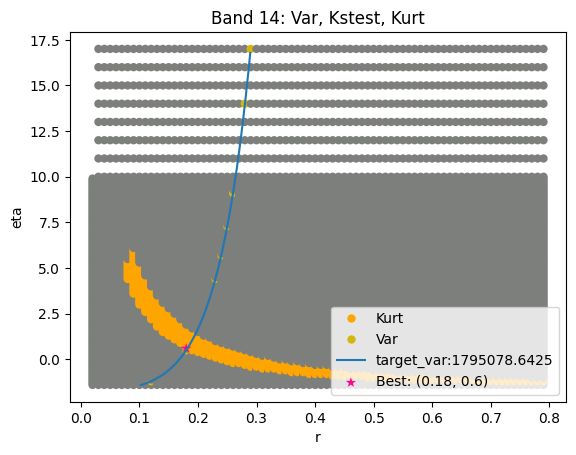

####
Band  17


100%|██████████| 51883/51883 [18:35<00:00, 46.52it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 8298440.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


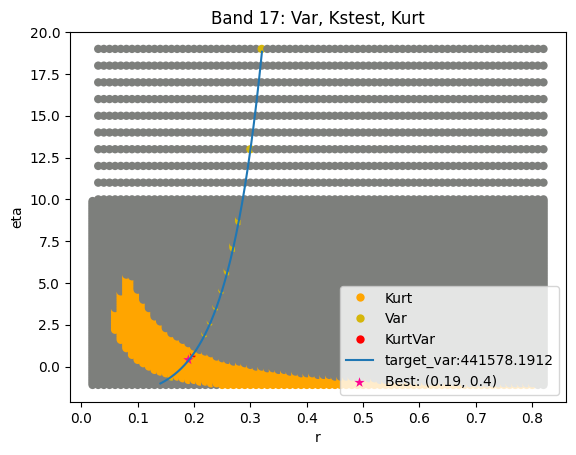

####
Band  20


100%|██████████| 51883/51883 [21:30<00:00, 40.19it/s]  


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 25140192.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


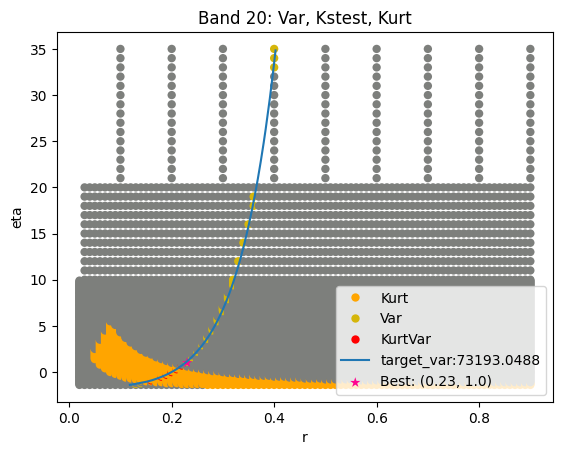

####
Band  23


100%|██████████| 51883/51883 [18:58<00:00, 45.57it/s]  


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 65734528.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


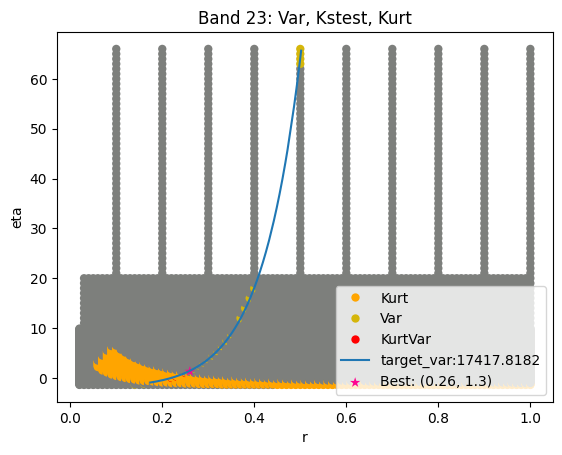

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
band,,,,,,,,,,,
2,2.108037e+08,2.039314e+08,2.177806e+08,5.938153,5.064412,6.961090,47614.0,0.16,1.6,0.013477,0.006220
5,8.466665e+07,8.227714e+07,8.714032e+07,10.238721,8.741003,12.021282,102030.0,0.16,1.1,0.013761,0.004250
8,2.441800e+07,2.372345e+07,2.514127e+07,10.654582,8.485845,14.080202,326496.0,0.17,1.2,0.013524,0.002376
11,6.095848e+06,5.934529e+06,6.261906e+06,9.481828,7.939621,11.507581,904666.0,0.17,0.6,0.012329,0.001428
14,1.795079e+06,1.744169e+06,1.849945e+06,11.123093,8.074008,16.063778,2727602.0,0.18,0.6,0.011311,0.000822
17,4.415782e+05,4.224831e+05,4.687009e+05,38.040094,9.508811,106.765547,8298440.0,0.19,0.4,0.009052,0.000471
20,7.319305e+04,6.723740e+04,8.394759e+04,212.947004,10.371002,573.653227,25140192.0,0.23,1.0,0.004751,0.000271
23,1.741782e+04,1.671122e+04,1.850959e+04,38.076744,6.192983,112.367262,65734528.0,0.26,1.3,0.005128,0.000168


In [11]:
''' Only need to run commented code once'''
sorted_params = sorted(all_cdfs)
group_cdf_df_dict = dict()

for i, group in enumerate(GROUPS):
    print(f"####\n{GROUP.capitalize()} ", group)
    sample = group_data_map[group]
    group_cdf_df = all_cdfs_df.copy()
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
    master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
    print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
    master_df.loc[group, 'kstest_stat_initial'] = min_stat
    cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

    group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
    
    group_cdf_df_dict[group] = group_cdf_df
    cols = ['pass_var', 'pass_kstest', 'pass_kurt']

    fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                          plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                          target_var = master_df.loc[group, 'obs_var'],
                          best_param = initial_param)
    
    fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

    # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
    # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

    # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    # plt.close(fig_var)
    # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    # plt.close(fig_kurt)

master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
pd.to_pickle(group_cdf_df_dict, os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))

group_cdf_df_dict = pd.read_pickle(os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"), index_col=GROUP)
master_df

In [12]:
''' Only need to run commented code once'''
best_params_eta0 = []
for i, group in enumerate(GROUPS):
    if master_df.loc[group, 'initial_eta'] != 0:
        sample = group_data_map[group]
        group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
        cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
        ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
        best_params_eta0.append(best_param_eta0[0])
        master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
    else:
        master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
        best_params_eta0.append(master_df.loc[group, 'initial_r'])
master_df['best_r_eta0'] = best_params_eta0
master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"), index_col=GROUP)
master_df

  0%|          | 0/369 [00:00<?, ?it/s]

100%|██████████| 369/369 [00:04<00:00, 75.83it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:09<00:00, 40.22it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:08<00:00, 43.54it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:07<00:00, 46.74it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:09<00:00, 40.40it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:08<00:00, 41.91it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:08<00:00, 45.58it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:07<00:00, 47.59it/s]

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
band,,,,,,,,,,,,,
2,2.108037e+08,2.039314e+08,2.177806e+08,5.938153,5.064412,6.961090,47614.0,0.16,1.6,0.013477,0.006220,0.042716,0.13
5,8.466665e+07,8.227714e+07,8.714032e+07,10.238721,8.741003,12.021282,102030.0,0.16,1.1,0.013761,0.004250,0.063720,0.14
8,2.441800e+07,2.372345e+07,2.514127e+07,10.654582,8.485845,14.080202,326496.0,0.17,1.2,0.013524,0.002376,0.060900,0.14
11,6.095848e+06,5.934529e+06,6.261906e+06,9.481828,7.939621,11.507581,904666.0,0.17,0.6,0.012329,0.001428,0.045692,0.15
14,1.795079e+06,1.744169e+06,1.849945e+06,11.123093,8.074008,16.063778,2727602.0,0.18,0.6,0.011311,0.000822,0.036923,0.16
17,4.415782e+05,4.224831e+05,4.687009e+05,38.040094,9.508811,106.765547,8298440.0,0.19,0.4,0.009052,0.000471,0.041412,0.18
20,7.319305e+04,6.723740e+04,8.394759e+04,212.947004,10.371002,573.653227,25140192.0,0.23,1.0,0.004751,0.000271,0.037241,0.20
23,1.741782e+04,1.671122e+04,1.850959e+04,38.076744,6.192983,112.367262,65734528.0,0.26,1.3,0.005128,0.000168,0.025837,0.21


In [13]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2
(0.152, 1.57), 50 of 441
(0.154, 1.65), 100 of 441
(0.157, 1.52), 150 of 441
(0.159, 1.6), 200 of 441
(0.161, 1.68), 250 of 441
(0.164, 1.55), 300 of 441
(0.166, 1.63), 350 of 441
(0.169, 1.5), 400 of 441


100%|██████████| 441/441 [00:03<00:00, 136.04it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 2 best parameters: ((0.159, 1.51), 0.012798011656144026)


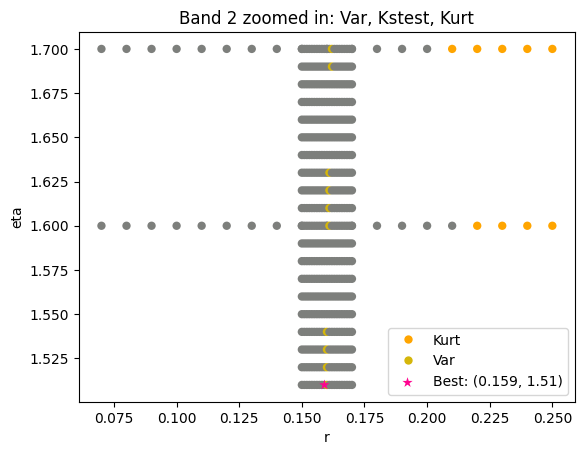

Band 5
(0.152, 1.07), 50 of 441
(0.154, 1.15), 100 of 441
(0.157, 1.02), 150 of 441
(0.159, 1.1), 200 of 441
(0.161, 1.18), 250 of 441
(0.164, 1.05), 300 of 441
(0.166, 1.13), 350 of 441
(0.169, 1.0), 400 of 441


100%|██████████| 441/441 [00:06<00:00, 68.60it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 5 best parameters: ((0.159, 1.04), 0.013544384505753848)


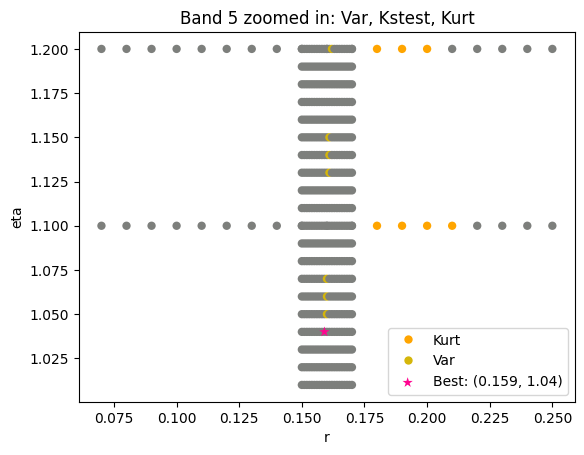

Band 8
(0.162, 1.17), 50 of 441
(0.164, 1.25), 100 of 441
(0.167, 1.12), 150 of 441
(0.169, 1.2), 200 of 441
(0.171, 1.28), 250 of 441
(0.174, 1.15), 300 of 441
(0.176, 1.23), 350 of 441
(0.179, 1.1), 400 of 441


100%|██████████| 441/441 [00:07<00:00, 55.29it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 8 best parameters: ((0.17, 1.14), 0.012260723977996268)


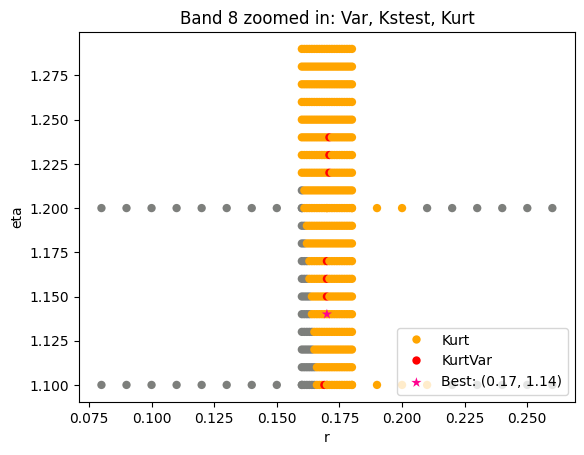

Band 11
(0.162, 0.59), 50 of 420
(0.164, 0.69), 100 of 420
(0.167, 0.59), 150 of 420
(0.169, 0.69), 200 of 420
(0.172, 0.59), 250 of 420
(0.174, 0.69), 300 of 420
(0.177, 0.59), 350 of 420
(0.179, 0.69), 400 of 420


100%|██████████| 420/420 [00:08<00:00, 48.80it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 11 best parameters: ((0.168, 0.53), 0.010325856200757655)


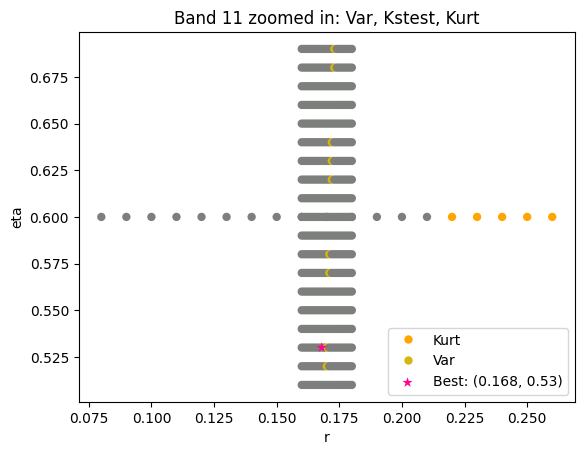

Band 14
(0.172, 0.59), 50 of 420
(0.174, 0.69), 100 of 420
(0.177, 0.59), 150 of 420
(0.179, 0.69), 200 of 420
(0.182, 0.59), 250 of 420
(0.184, 0.69), 300 of 420
(0.187, 0.59), 350 of 420
(0.189, 0.69), 400 of 420


100%|██████████| 420/420 [00:08<00:00, 51.20it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 14 best parameters: ((0.18, 0.55), 0.00927943162600442)


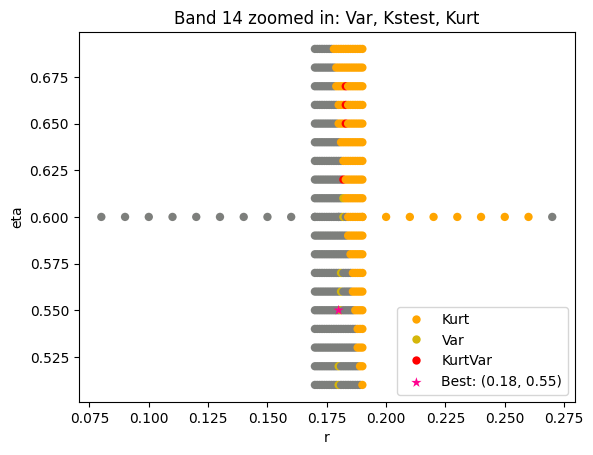

Band 17
(0.182, 0.39), 50 of 420
(0.184, 0.49), 100 of 420
(0.187, 0.39), 150 of 420
(0.189, 0.49), 200 of 420
(0.192, 0.39), 250 of 420
(0.194, 0.49), 300 of 420
(0.197, 0.39), 350 of 420
(0.199, 0.49), 400 of 420


100%|██████████| 420/420 [00:08<00:00, 50.42it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 17 best parameters: ((0.19, 0.42), 0.005314798866771775)


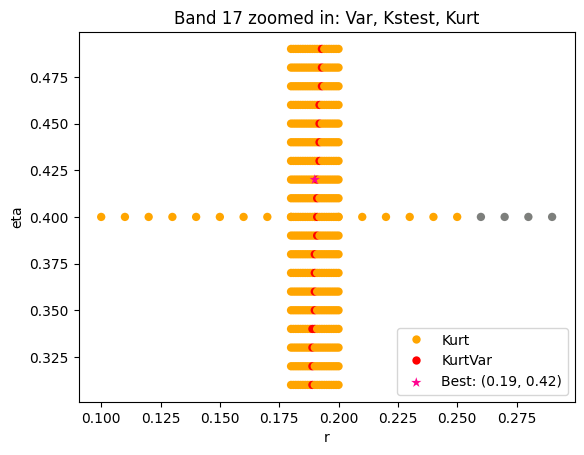

Band 20
(0.222, 0.97), 50 of 441
(0.224, 1.05), 100 of 441
(0.227, 0.92), 150 of 441
(0.229, 1.0), 200 of 441
(0.231, 1.08), 250 of 441
(0.234, 0.95), 300 of 441
(0.236, 1.03), 350 of 441
(0.239, 0.9), 400 of 441


100%|██████████| 441/441 [00:08<00:00, 53.19it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 20 best parameters: ((0.227, 0.9), 0.0036525907902837107)


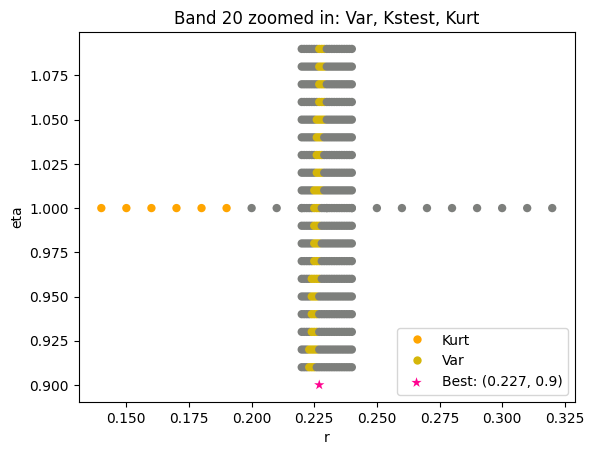

Band 23
(0.252, 1.27), 50 of 441
(0.254, 1.35), 100 of 441
(0.257, 1.22), 150 of 441
(0.259, 1.3), 200 of 441
(0.261, 1.38), 250 of 441
(0.264, 1.25), 300 of 441
(0.266, 1.33), 350 of 441
(0.269, 1.2), 400 of 441


100%|██████████| 441/441 [00:43<00:00, 10.23it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 23 best parameters: ((0.257, 1.22), 0.0033468596354605806)


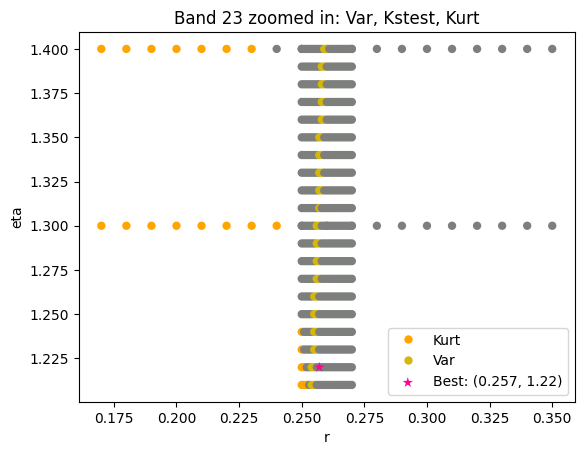

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0,best_r,best_eta,kstest_stat_best,iter1_r,iter1_eta,kstest_stat_iter1,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,2.108037e+08,2.039314e+08,2.177806e+08,5.938153,5.064412,6.961090,47614.0,0.16,1.6,0.013477,0.006220,0.042716,0.13,0.159,1.51,0.012798,0.159,1.51,0.012798,11903
5,8.466665e+07,8.227714e+07,8.714032e+07,10.238721,8.741003,12.021282,102030.0,0.16,1.1,0.013761,0.004250,0.063720,0.14,0.159,1.04,0.013544,0.159,1.04,0.013544,9564
8,2.441800e+07,2.372345e+07,2.514127e+07,10.654582,8.485845,14.080202,326496.0,0.17,1.2,0.013524,0.002376,0.060900,0.14,0.170,1.14,0.012261,0.170,1.14,0.012261,12912
11,6.095848e+06,5.934529e+06,6.261906e+06,9.481828,7.939621,11.507581,904666.0,0.17,0.6,0.012329,0.001428,0.045692,0.15,0.168,0.53,0.010326,0.168,0.53,0.010326,17887
14,1.795079e+06,1.744169e+06,1.849945e+06,11.123093,8.074008,16.063778,2727602.0,0.18,0.6,0.011311,0.000822,0.036923,0.16,0.180,0.55,0.009279,0.180,0.55,0.009279,21309
17,4.415782e+05,4.224831e+05,4.687009e+05,38.040094,9.508811,106.765547,8298440.0,0.19,0.4,0.009052,0.000471,0.041412,0.18,0.190,0.42,0.005315,0.190,0.42,0.005315,64831
20,7.319305e+04,6.723740e+04,8.394759e+04,212.947004,10.371002,573.653227,25140192.0,0.23,1.0,0.004751,0.000271,0.037241,0.20,0.227,0.90,0.003653,0.227,0.90,0.003653,139822
23,1.741782e+04,1.671122e+04,1.850959e+04,38.076744,6.192983,112.367262,65734528.0,0.26,1.3,0.005128,0.000168,0.025837,0.21,0.257,1.22,0.003347,0.257,1.22,0.003347,162489


In [14]:
SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1, 1, 1, 1, 1, 1, 1, 1]))
NUM_SAMPLES_OPTIMIZE = 2000

if SKIP_OPTIMIZE_STEP:
    master_df['kstest_stat'] = master_df['kstest_stat_initial']
    master_df[f'best_r'] = master_df['initial_r']
    master_df[f'best_eta'] = master_df['initial_eta']
else:
    for group in GROUPS: 
        print(f"{GROUP.capitalize()} {group}")
        sample = group_data_map[group]
        initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
        r_granularity = 10
        eta_granularity = 10
        for i in range(-1, -5, -1):
            if tuple([round_to_sigfigs(initial_r + 10.**i), initial_eta]) in all_cdfs:
                r_granularity = 10.**i
            if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i)]) in all_cdfs:
                
                eta_granularity = 10.**i

        for d in range(1, NUM_ITERS[group] + 1):
            if d == 1:
                initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            else:
                initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
            r_granularity = r_granularity * 10.0**(-d+1) 
            eta_granularity = eta_granularity * 10.0**(-d+1) 

            r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
            eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
            simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
            cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
            ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

            temp_df = create_kurt_var_ksstat_df(cdfs_dict)
            temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
            group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
            master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
            master_df.loc[group, 'kstest_stat_best'] = kstest_stat
            master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
            master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
            
            print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

        temp_df = group_cdf_df_dict[group]
        eps = 0.1
        filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                        (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                        (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                        (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']
        fig = combo_test_plot(filtered_df, cols, 
                              plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                              best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
        fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
        
master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', f'best_r', f'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'), index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

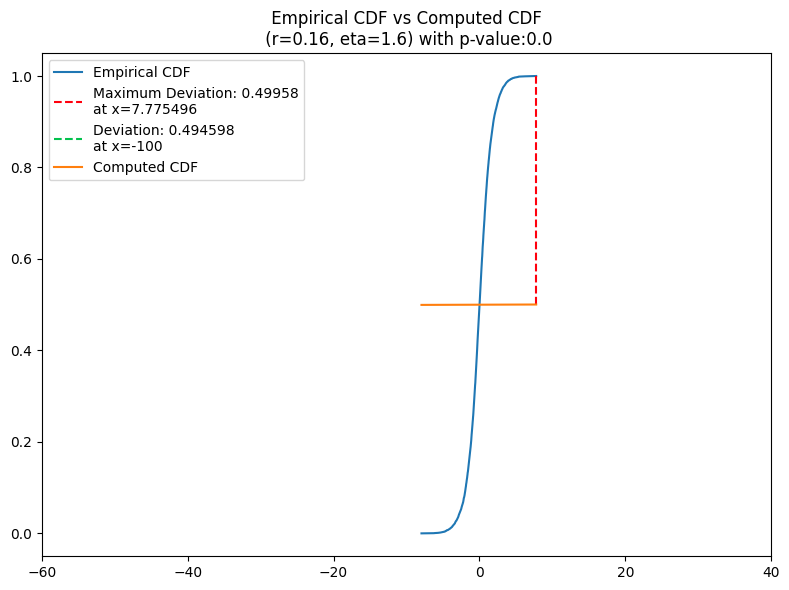

In [15]:
# Example Cell
group = 2
visualize_cdf(sample = sample_prior(1, 1, 10000), 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

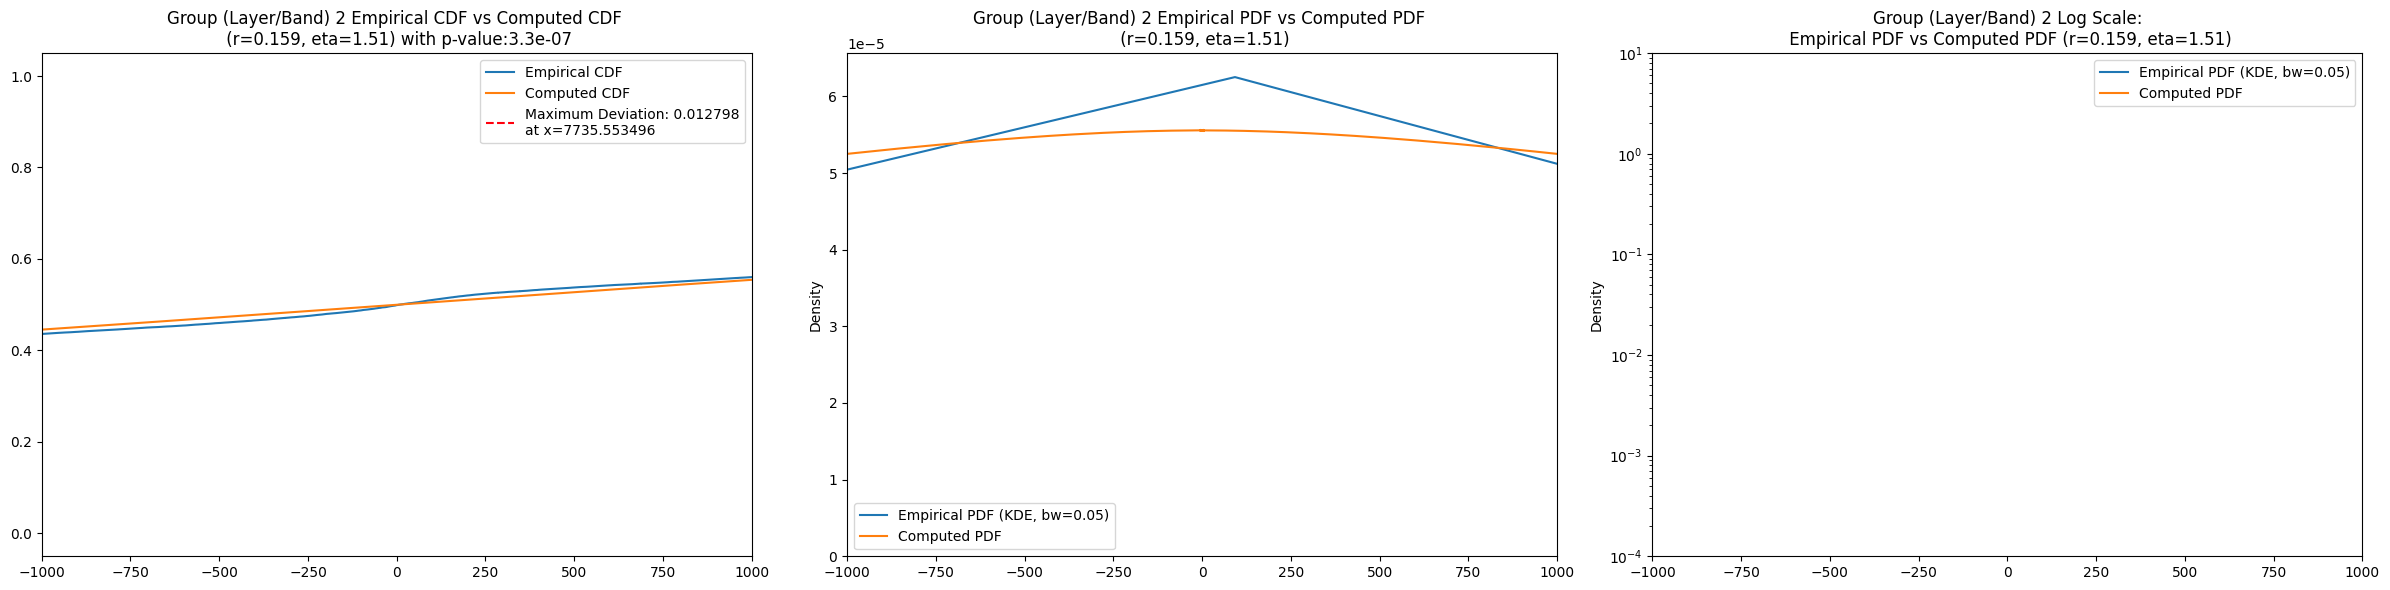

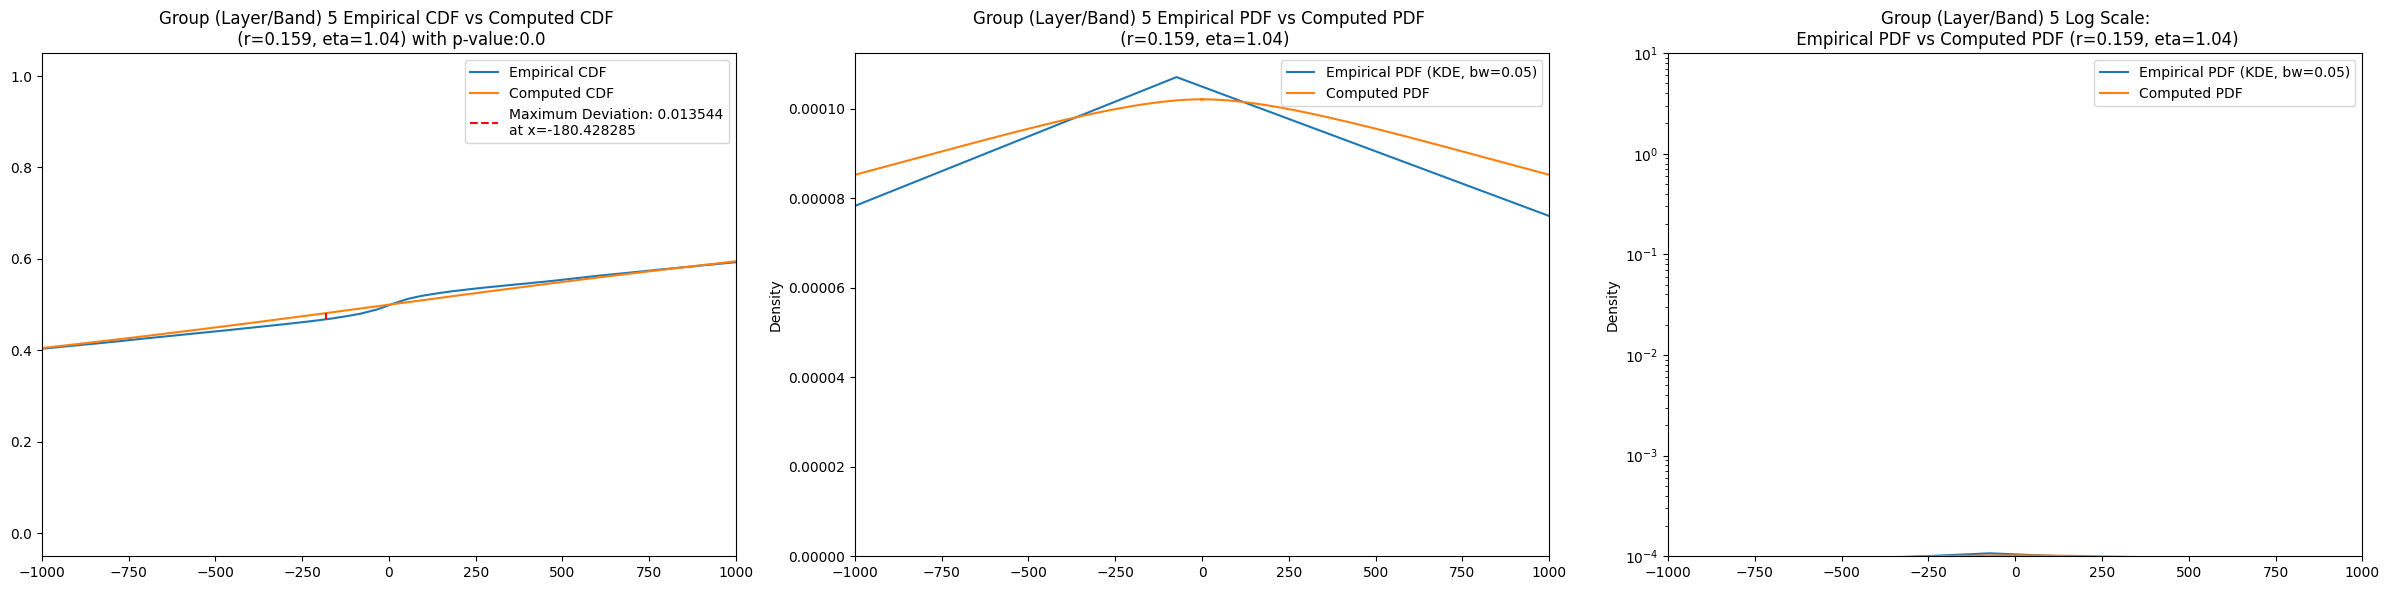

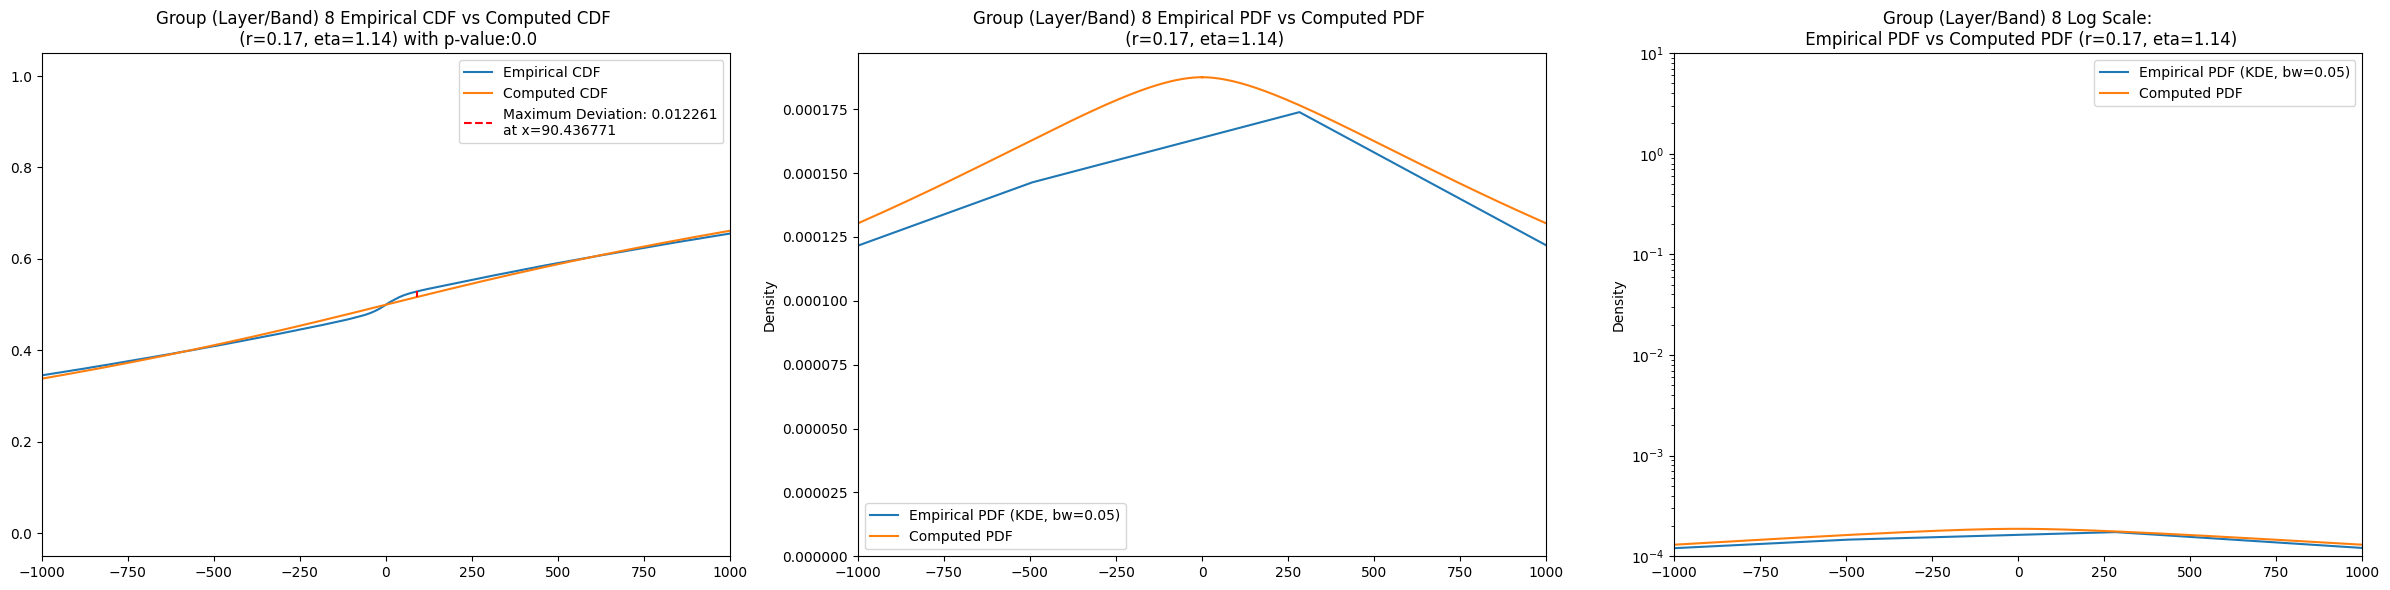

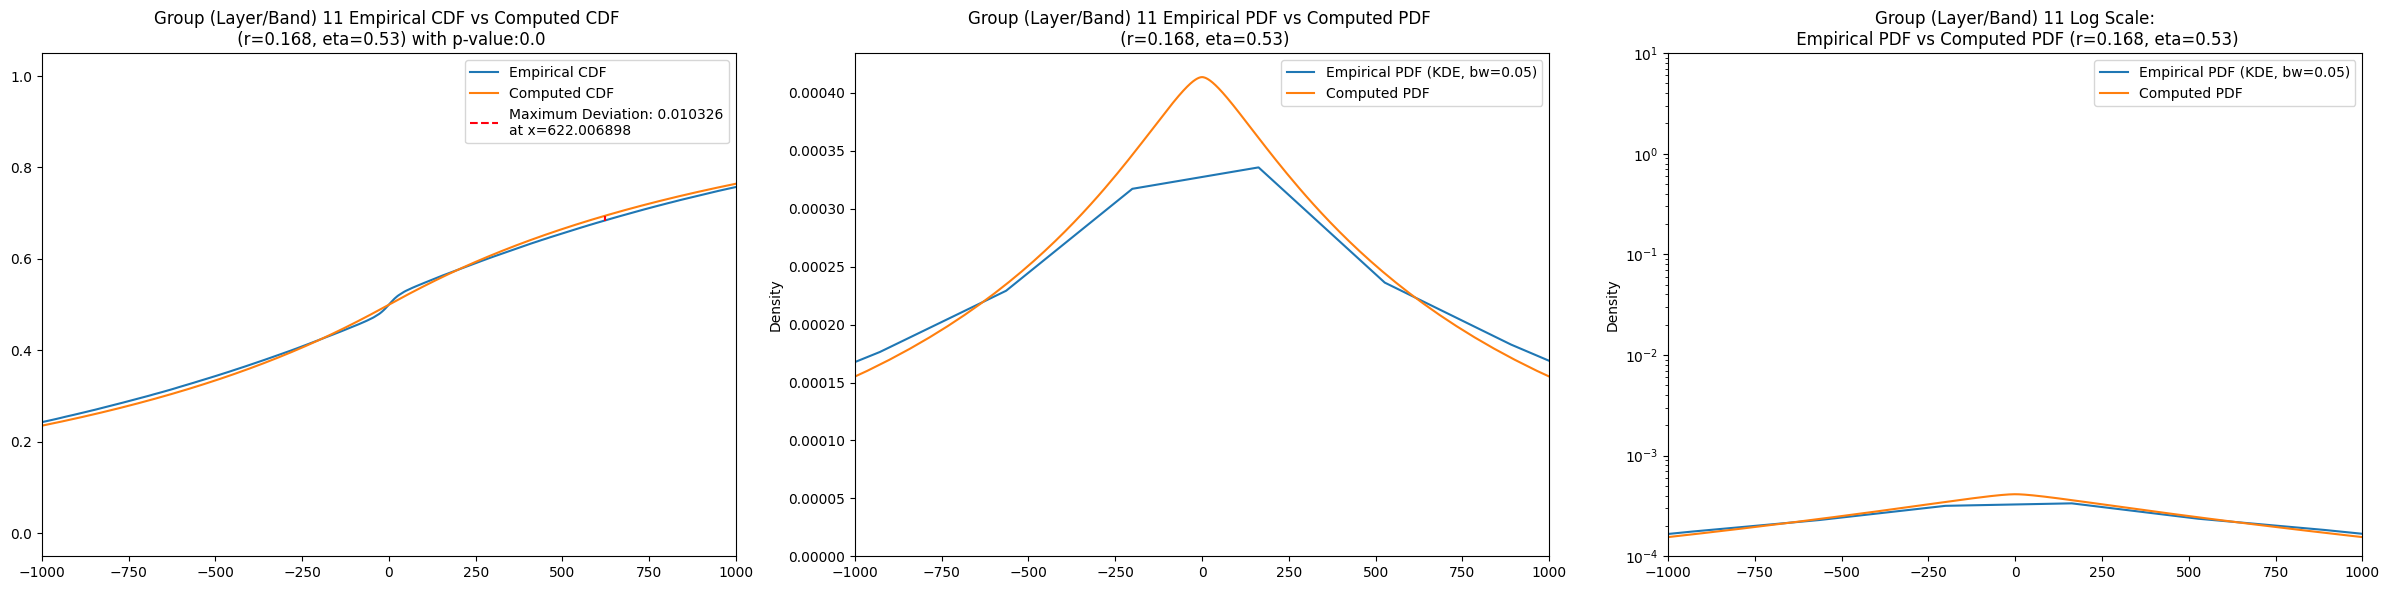

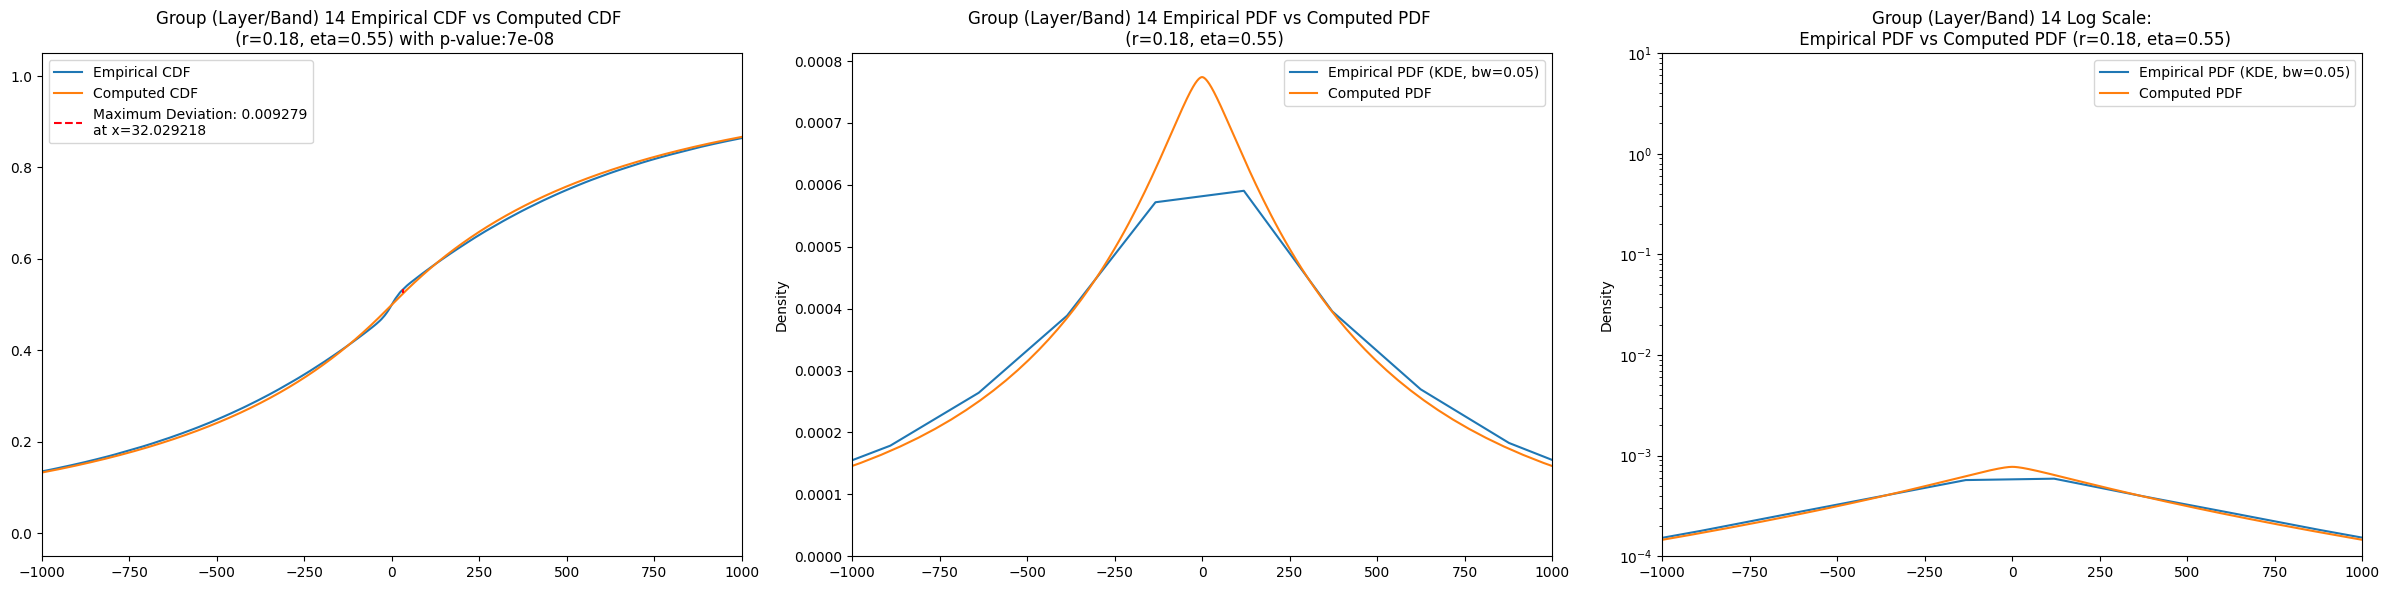

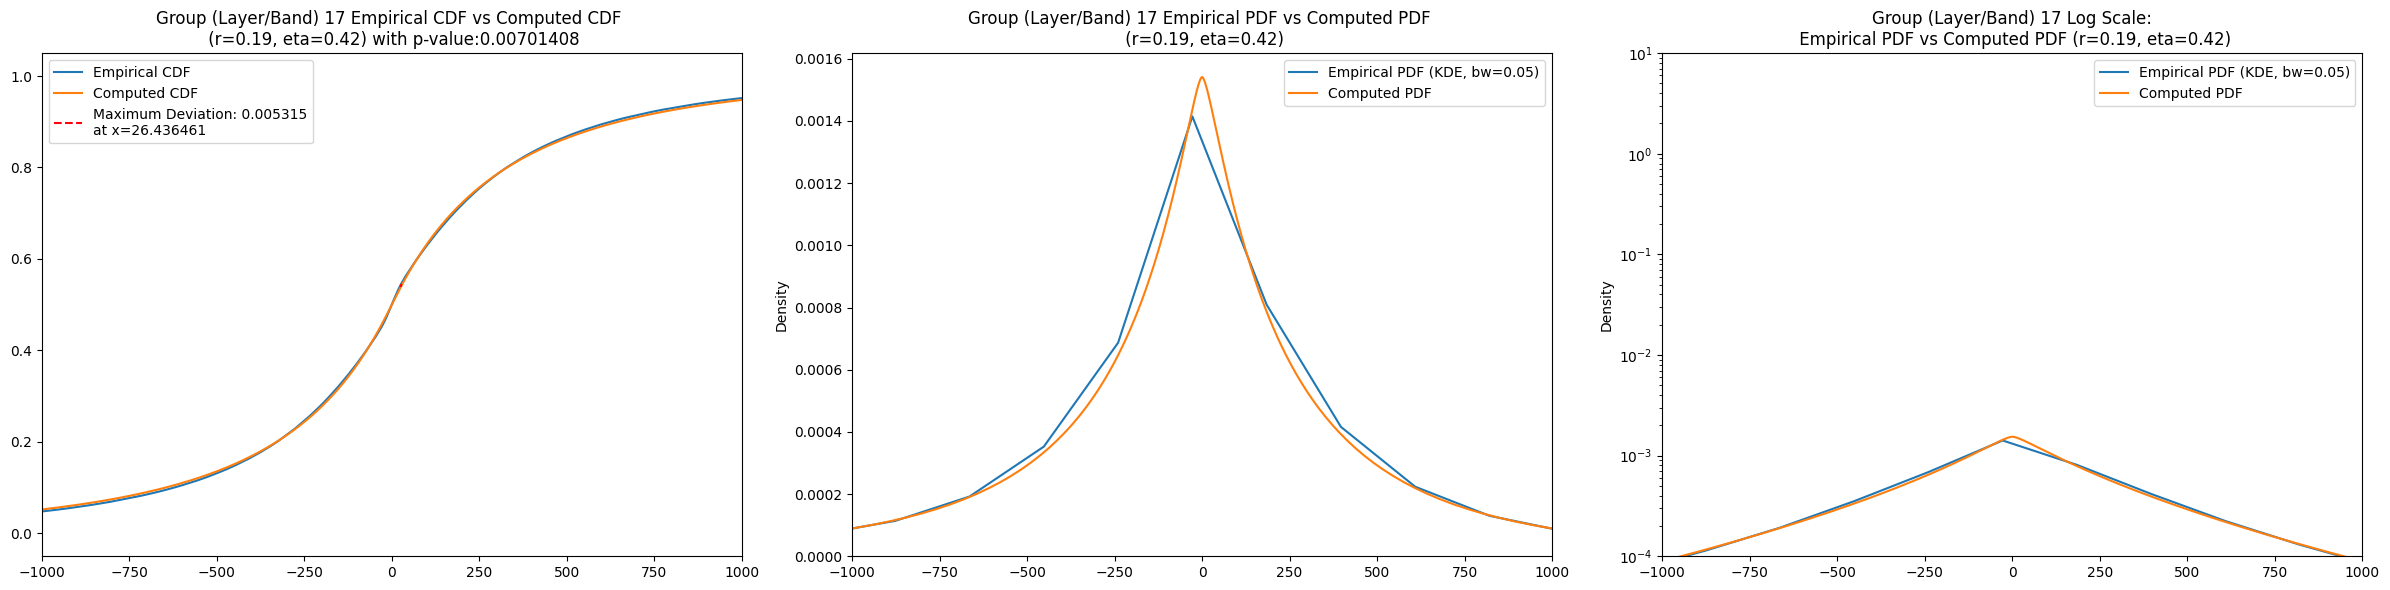

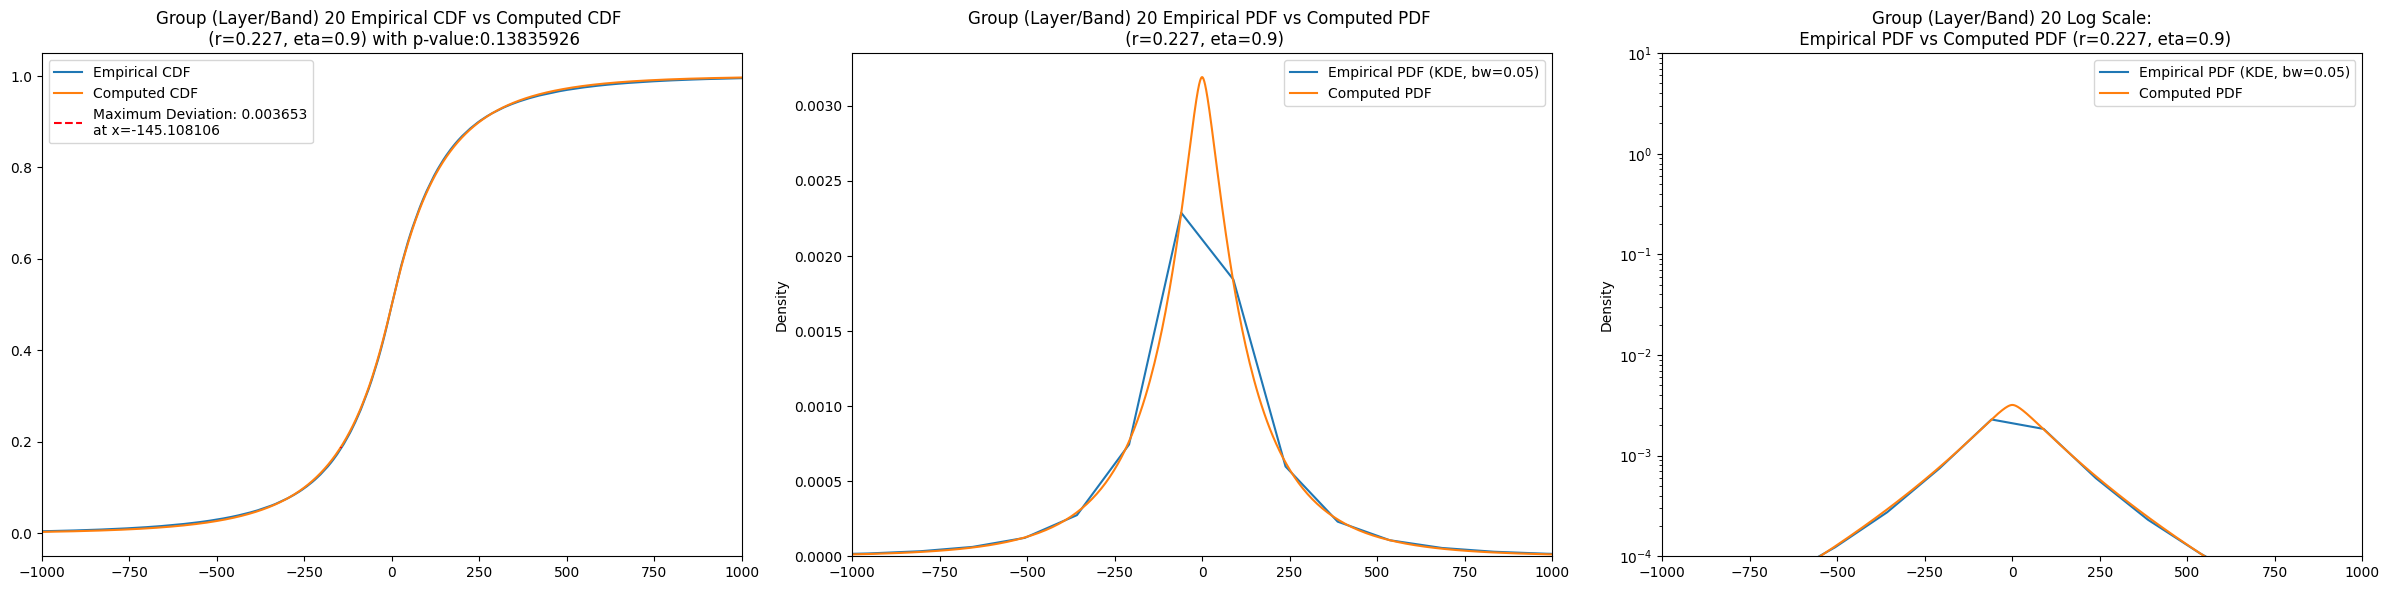

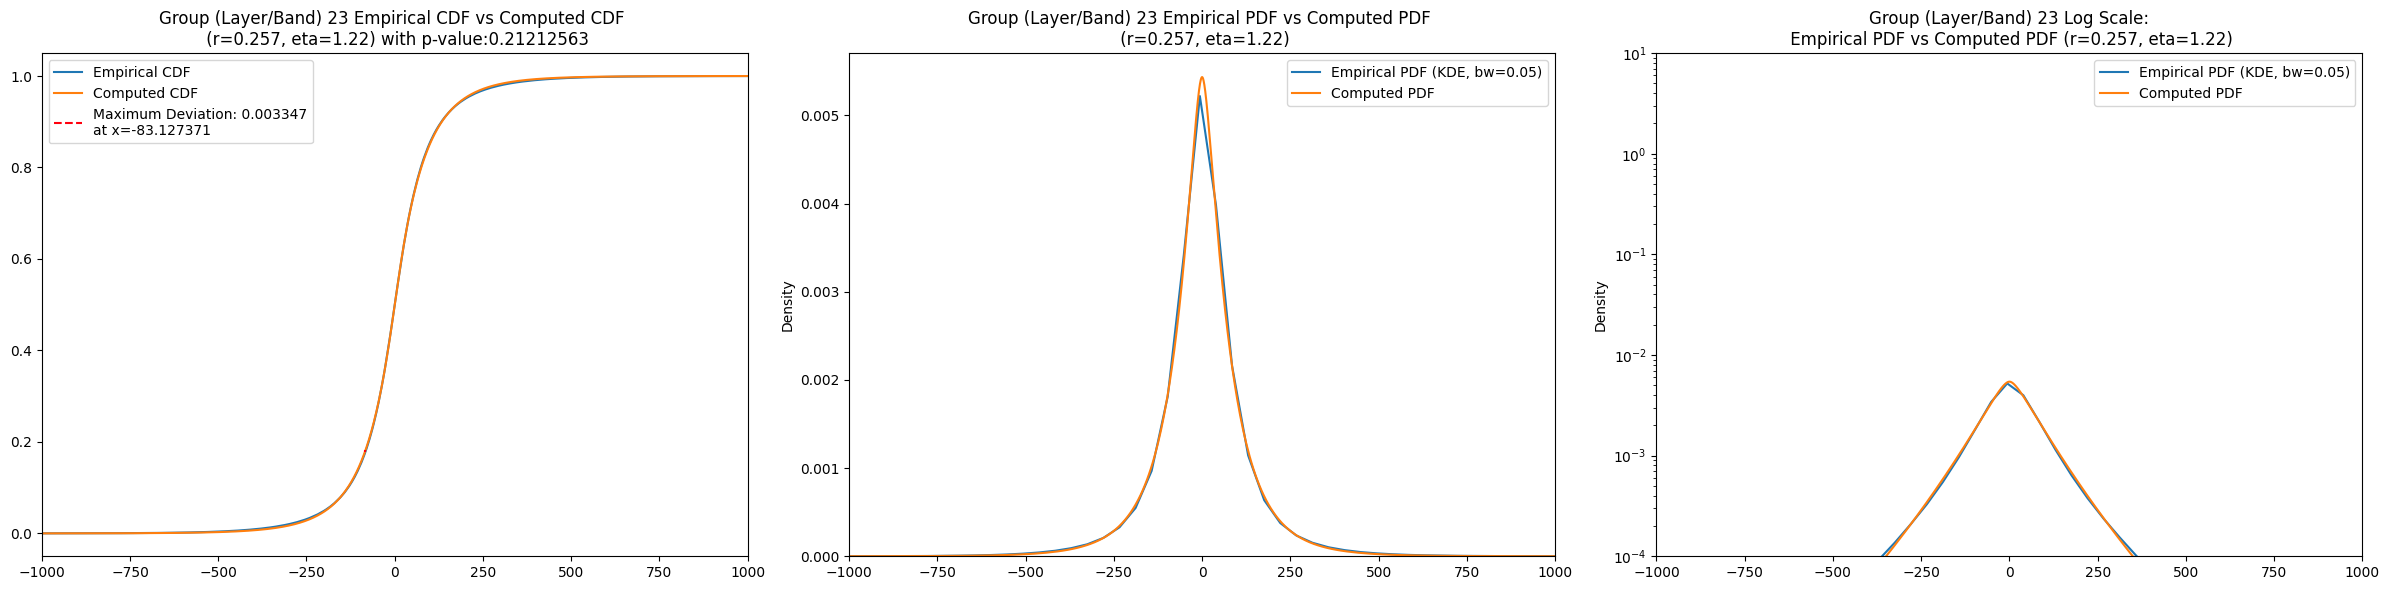

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-1000, 1000))#,
                    #provided_loc=(30 - group//3.1*8))
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [18]:
for group in GROUPS:
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,2.108037e+08,2.039314e+08,2.177806e+08,5.938153,5.064412,6.961090,47614.0,0.16,1.6,0.013477,...,50.0,0.483223,0.0,50.0,0.472632,0.0,50.0,0.460557,0.0,3.336400e-07
5,8.466665e+07,8.227714e+07,8.714032e+07,10.238721,8.741003,12.021282,102030.0,0.16,1.1,0.013761,...,50.0,0.472709,0.0,50.0,0.461436,0.0,50.0,0.447531,0.0,1.093300e-16
8,2.441800e+07,2.372345e+07,2.514127e+07,10.654582,8.485845,14.080202,326496.0,0.17,1.2,0.013524,...,50.0,0.460322,0.0,50.0,0.444359,0.0,50.0,0.426896,0.0,4.625900e-43
11,6.095848e+06,5.934529e+06,6.261906e+06,9.481828,7.939621,11.507581,904666.0,0.17,0.6,0.012329,...,50.0,0.439446,0.0,50.0,0.415643,0.0,50.0,0.394897,0.0,3.260700e-84
14,1.795079e+06,1.744169e+06,1.849945e+06,11.123093,8.074008,16.063778,2727602.0,0.18,0.6,0.011311,...,50.0,0.405877,0.0,50.0,0.372726,0.0,50.0,0.349835,0.0,1.970800e-204
17,4.415782e+05,4.224831e+05,4.687009e+05,38.040094,9.508811,106.765547,8298440.0,0.19,0.4,0.009052,...,50.0,0.348485,0.0,50.0,0.306069,0.0,50.0,0.282157,0.0,4.970100e-204
20,7.319305e+04,6.723740e+04,8.394759e+04,212.947004,10.371002,573.653227,25140192.0,0.23,1.0,0.004751,...,50.0,0.233051,0.0,50.0,0.186356,0.0,50.0,0.162028,0.0,9.335900e-292
23,1.741782e+04,1.671122e+04,1.850959e+04,38.076744,6.192983,112.367262,65734528.0,0.26,1.3,0.005128,...,50.0,0.130575,0.0,50.0,0.088026,0.0,50.0,0.062243,0.0,0.000000e+00


# Examining Tail Behavior

In [19]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

# Results

## KS-Test Statistics

In [20]:
import pandas as pd
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

In [23]:
master_df.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,kstest_stat_best,kstest_stat_iter1,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
0,47614.0,0.013477,0.006220,0.042716,0.012798,0.012798,0.483223,0.472632,0.460557
1,102030.0,0.013761,0.004250,0.063720,0.013544,0.013544,0.472709,0.461436,0.447531
2,326496.0,0.013524,0.002376,0.060900,0.012261,0.012261,0.460322,0.444359,0.426896
3,904666.0,0.012329,0.001428,0.045692,0.010326,0.010326,0.439446,0.415643,0.394897
4,2727602.0,0.011311,0.000822,0.036923,0.009279,0.009279,0.405877,0.372726,0.349835
5,8298440.0,0.009052,0.000471,0.041412,0.005315,0.005315,0.348485,0.306069,0.282157
6,25140192.0,0.004751,0.000271,0.037241,0.003653,0.003653,0.233051,0.186356,0.162028
7,65734528.0,0.005128,0.000168,0.025837,0.003347,0.003347,0.130575,0.088026,0.062243
